In [47]:
import pandas as pd
from scipy import stats
from pylab import rcParams
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import seaborn as sns

### Download dataset 1) MutSpec of vertebrates; 2) asymmetry in nuclear genome; 3) Human Global Tree MutSpec with T nad R

In [91]:
assymetry = pd.read_table('../data/external/T-R_plot_allCpG.txt', sep=' ', header=None)
mut_vert = pd.read_csv('../data/MutSpecALLvert.csv')
hgt = pd.read_csv('https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/kpotoh/data/processed/HGT_asymmetry_major_arc.csv')


In [49]:
hgt.head()

,Cxt,MutBase,T,R,Mut,Asymmetry,HGT_Asymmetry_log2
0,ACA,C>A,-0.171181,-0.373510,A[C>A]A,NaN,NaN
1,ACA,C>G,0.065067,0.034147,A[C>G]A,NaN,NaN
2,ACA,C>T,-0.012015,-0.052744,A[C>T]A,7.101136,2.82805
3,ACC,C>A,-0.091167,-0.285840,A[C>A]C,NaN,NaN
4,ACC,C>G,0.091991,0.144789,A[C>G]C,NaN,NaN


In [50]:
mut_vert['MutBase'] = mut_vert.Mut.str.slice(2,5)
mut_vert['AncestorCodon'] = mut_vert.Mut.str.get(0) + mut_vert.Mut.str.get(2) + mut_vert.Mut.str.get(-1)
mut_vert.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,A[A>C]A,0.000424,A>C,AAA
1,A[A>C]C,0.001497,A>C,AAC
2,A[A>C]G,0.000197,A>C,AAG
3,A[A>C]T,0.000000,A>C,AAT
4,A[A>G]A,0.014522,A>G,AAA


In [117]:
assymetry = assymetry.rename(columns={0:'AncestorCodon', 1:'MutBase', 2:'T', 3:'R'})
assymetry.head()

,AncestorCodon,MutBase,T,R
0,ACA,C>A,-0.171181,-0.373510
1,ACA,C>G,0.065067,0.034147
2,ACA,C>T,-0.012015,-0.052744
3,ACC,C>A,-0.091167,-0.285840
4,ACC,C>G,0.091991,0.144789


### Translate 192 mtDNA mutspec to 96 component

In [52]:
def gettranslate(mut, reverse=True):
    translator = str.maketrans("ACGT", "TGCA")
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(translator)
    return new_mut

In [53]:
def transform192_to96(asymmetry_df, df_transform):
    to_96_comp = []
    for num_subs in range(0,96):
        # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
        anc = asymmetry_df.iloc[num_subs, 0]
        mb = asymmetry_df.iloc[num_subs, 1]
        # get reverse subs with context
        rev_anc = gettranslate(anc, reverse=True)
        rev_mb = gettranslate(mb, reverse=False)
        # find mutspec num for the mutbase and context same with reverse, than devide on reverse
        rev_mutspec = df_transform[(df_transform.MutBase == rev_mb) & (df_transform.AncestorCodon == rev_anc)].MutSpec.values[0]
        mutspec = df_transform[(df_transform.MutBase == mb) & (df_transform.AncestorCodon == anc)].MutSpec.values[0]
        new_96_mut = mutspec/rev_mutspec
        #define row for future df
        out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
        to_96_comp.append(out_mut)

    mut_96_comp = pd.DataFrame(to_96_comp)
    mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].replace(np.inf, 0)
    mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].fillna(0)
    return(mut_96_comp)
    

In [54]:
mut_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=mut_vert)
mut_96_comp.head()

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_23121/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_23121/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


,AncestorCodon,MutBase,MutSpec
0,ACA,C>A,0.000000
1,ACA,C>G,0.000000
2,ACA,C>T,3.473528
3,ACC,C>A,0.000000
4,ACC,C>G,0.000000


In [55]:
final_asymmetry = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
final_asymmetry = final_asymmetry[final_asymmetry.MutSpec != 0]
final_asymmetry.MutSpec = np.log2(final_asymmetry.MutSpec)
final_asymmetry.head()

,AncestorCodon,MutBase,T,R,MutSpec
2,ACA,C>T,-0.012015,-0.052744,1.796402
5,ACC,C>T,0.028556,-0.069531,2.329356
8,ACG,C>T,0.071747,0.012317,1.465678
11,ACT,C>T,-0.088058,-0.074512,1.504908
13,ATA,T>C,-0.320754,-0.774055,-2.192291


### Complete cor test for t and r asymmetry and mtDNA mutSpec

In [88]:
t_cor = stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0)
t_cor

SignificanceResult(statistic=0.6386990876817956, pvalue=4.618983340981669e-09)

In [89]:
r_cor = stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values)
r_cor

SignificanceResult(statistic=0.6245753330534031, pvalue=1.2563866833839332e-08)

### Draw plot for T and R asymmetry and mutspec

In [59]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [60]:
final_asymmetry = final_asymmetry.rename(columns={'MutBase':'Mutation Base'})

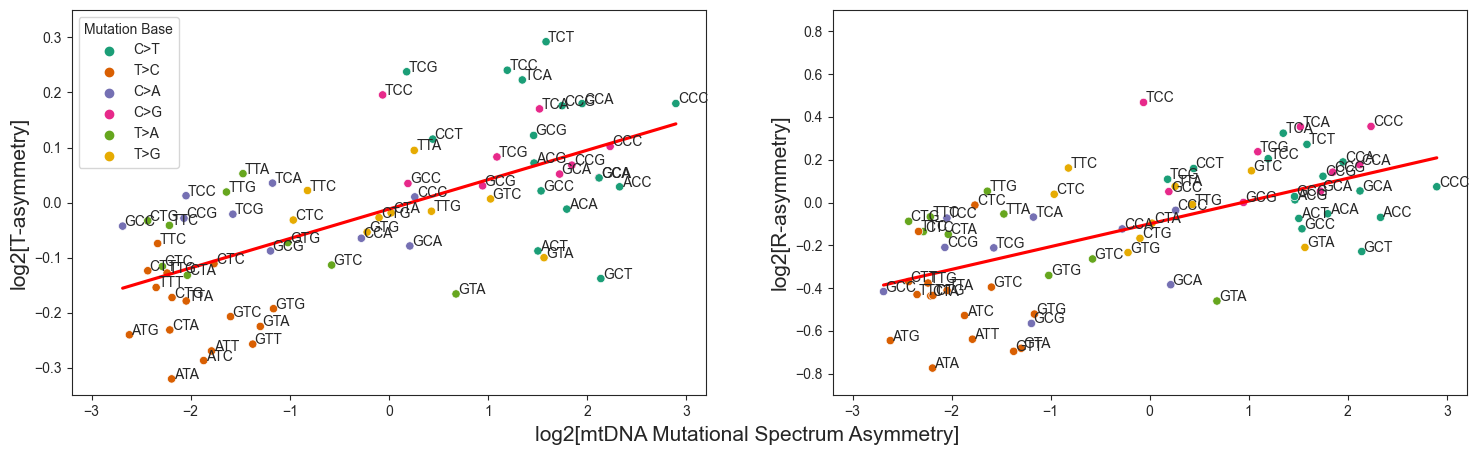

In [80]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(18,5))

sns.scatterplot(data = final_asymmetry, x='MutSpec', y='T', hue='Mutation Base', ax=axes[0], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['T'], final_asymmetry.AncestorCodon, axes[0])
sns.regplot(data=final_asymmetry, x='MutSpec', y='T', ci=None, scatter=False,color='red', ax=axes[0])
#axes[0].legend([],[], frameon=False)
axes[0].set_xlim(-3.2,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel('')
axes[0].set_ylabel('log2[T-asymmetry]', size=15)


sns.scatterplot(data = final_asymmetry, x='MutSpec', y='R', hue='Mutation Base', ax=axes[1], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['R'], final_asymmetry.AncestorCodon, axes[1])
sns.regplot(data=final_asymmetry, x='MutSpec', y='R', ci=None, scatter=False,color='red', ax=axes[1])
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-3.2,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel('')
axes[1].set_ylabel('log2[R-asymmetry]', size = 15)
fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
#fig.savefig('../pictures/AsymmetryTRM.pdf', dpi=300)

In [85]:
#final_asymmetry.to_csv('../data/asymmetry_mutspec.csv', index=False)

### Error bar for mtDNA MutSpec asymmetry

In [81]:
err_dt = final_asymmetry.groupby('Mutation Base').agg(
    T_mean = pd.NamedAgg(column='T', aggfunc='mean'),
    T_sd = pd.NamedAgg(column='T', aggfunc='std'),
    R_mean = pd.NamedAgg(column='R', aggfunc='mean'),
    R_sd = pd.NamedAgg(column='R', aggfunc='std'),
    mut_mean = pd.NamedAgg(column='MutSpec', aggfunc='mean'),
    mut_sd = pd.NamedAgg(column='MutSpec', aggfunc='std')).reset_index()

In [32]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-1.171815,1.048685
1,C>G,0.086727,0.059437,0.204274,0.161479,1.290310,0.815506
2,C>T,0.105891,0.123658,0.062509,0.149783,1.606742,0.662963
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-1.443938,1.006378
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.966376,0.433882
5,T>G,-0.013905,0.053733,-0.032676,0.150795,0.133466,0.810865


In [82]:
# sort MutBase values as in scatter plot
err_dt['Mutation Base'] = pd.Categorical(err_dt['Mutation Base'], ['C>T', 'T>C', 'C>A', 'C>G', 'T>A', 'T>G'])
err_dt = err_dt.sort_values(['Mutation Base'])

In [34]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
2,C>T,0.105891,0.123658,0.062509,0.149783,1.606742,0.662963
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.966376,0.433882
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-1.171815,1.048685
1,C>G,0.086727,0.059437,0.204274,0.161479,1.290310,0.815506
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-1.443938,1.006378
5,T>G,-0.013905,0.053733,-0.032676,0.150795,0.133466,0.810865


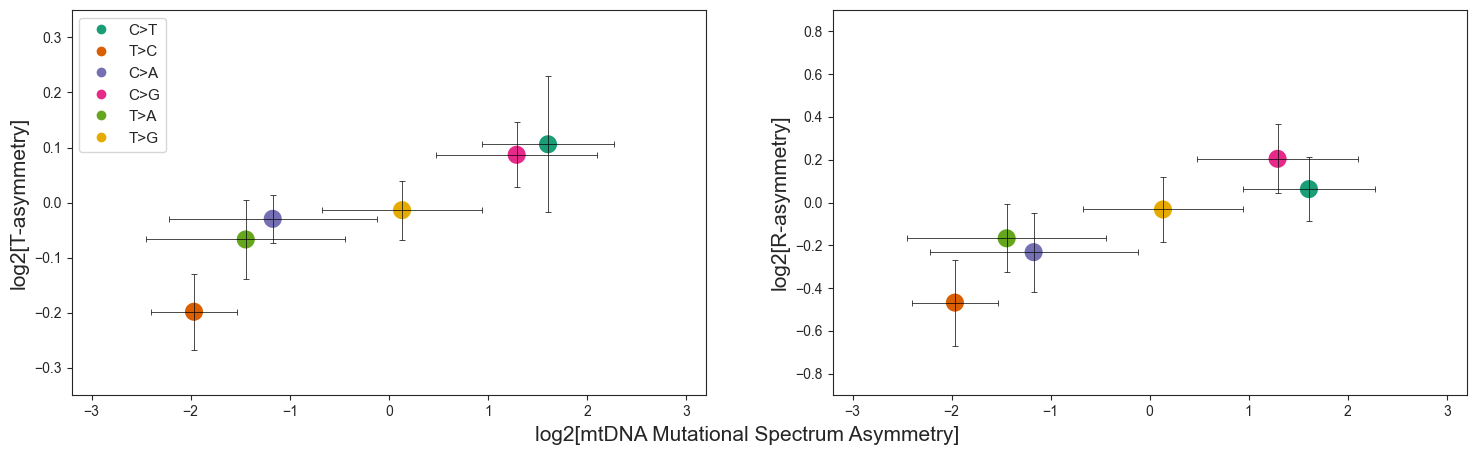

In [86]:
fig, axes = plt.subplots(1,2, sharex=False, figsize=(18,5))
sns.set_style("ticks")

sns.scatterplot(y="T_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[0])
axes[0].errorbar(y="T_mean", x="mut_mean", xerr='mut_sd', yerr='T_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[0].tick_params(axis='x')
axes[0].legend(loc='upper left', scatteryoffsets=[0.55], frameon=True, fontsize=11, ncol=1)
axes[0].set_xlim(-3.2,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel("")
axes[0].set_ylabel("log2[T-asymmetry]", fontsize=15)


sns.scatterplot(y="R_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[1])
axes[1].errorbar(y="R_mean", x="mut_mean", xerr='mut_sd', yerr='R_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[1].tick_params(axis='x')
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-3.2,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel("")
axes[1].set_ylabel("log2[R-asymmetry]", fontsize=15)

fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
fig.savefig("../pictures/AsymmetryErrorBars.pdf", dpi=300)

### Plots for HGT

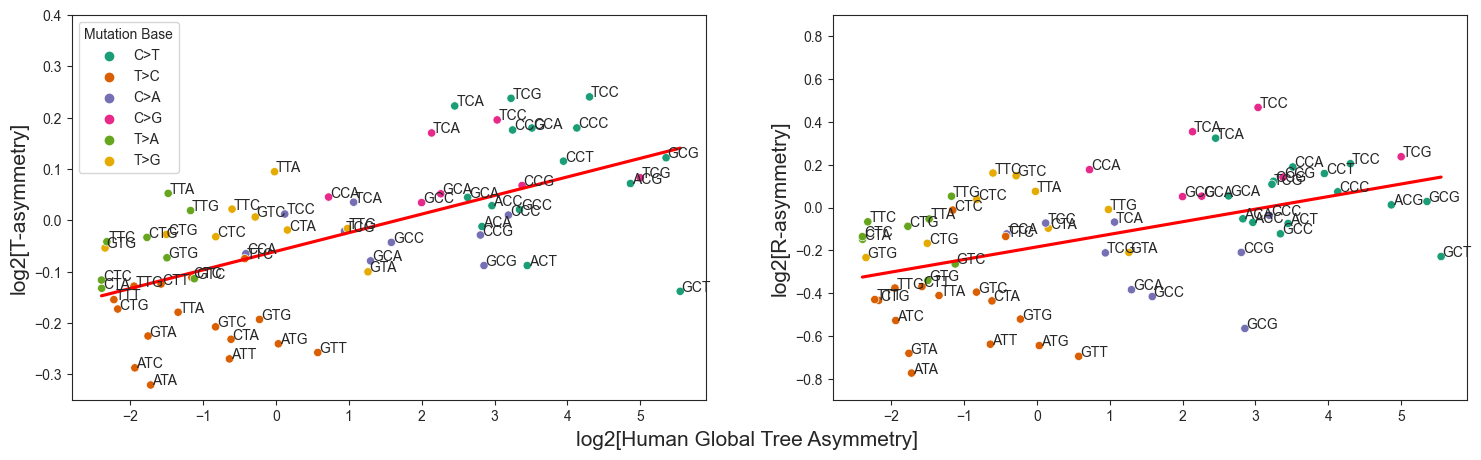

In [152]:
hgt_cl = hgt.dropna()
hgt_cl = hgt_cl.rename(columns={'MutBase':'Mutation Base'})
fig, axes = plt.subplots(1,2, sharex=True, figsize=(18,5))

sns.scatterplot(data = hgt_cl, x='HGT_Asymmetry_log2', y='T', hue='Mutation Base', ax=axes[0], palette='Dark2')
label_point(hgt_cl.HGT_Asymmetry_log2, hgt_cl['T'], hgt_cl.Cxt, axes[0])
sns.regplot(data=hgt_cl, x='HGT_Asymmetry_log2', y='T', ci=None, scatter=False, color='red', ax=axes[0])
#axes[0].legend([],[], frameon=False)
axes[0].set_xlim(-2.8,5.9)
axes[0].set_ylim(-0.35,0.4)
axes[0].set_xlabel('')
axes[0].set_ylabel('log2[T-asymmetry]', size=15)


sns.scatterplot(data = hgt_cl, x='HGT_Asymmetry_log2', y='R', hue='Mutation Base', ax=axes[1], palette='Dark2')
label_point(hgt_cl.HGT_Asymmetry_log2, hgt_cl['R'], hgt_cl.Cxt, axes[1])
sns.regplot(data=hgt_cl, x='HGT_Asymmetry_log2', y='R', ci=None, scatter=False, color='red', ax=axes[1])
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-2.8,5.9)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel('')
axes[1].set_ylabel('log2[R-asymmetry]', size=15)
fig.supxlabel('log2[Human Global Tree Asymmetry]', size=15)
fig.savefig('../pictures/AsymmetryHGT.pdf', dpi=300)

### Error bars for HGT

In [231]:
hgt_cl.head()

,Cxt,MutBase,T,R,Mut,Asymmetry,HGT_Asymmetry_log2
2,ACA,C>T,-0.012015,-0.052744,A[C>T]A,7.101136,2.828050
5,ACC,C>T,0.028556,-0.069531,A[C>T]C,7.808199,2.964990
8,ACG,C>T,0.071747,0.012317,A[C>T]G,29.144920,4.865173
11,ACT,C>T,-0.088058,-0.074512,A[C>T]T,10.921100,3.449046
13,ATA,T>C,-0.320754,-0.774055,A[T>C]A,0.303984,-1.717934


In [232]:
err_hgt = hgt_cl.groupby('MutBase').agg(
    T_mean = pd.NamedAgg(column='T', aggfunc='mean'),
    T_sd = pd.NamedAgg(column='T', aggfunc='std'),
    R_mean = pd.NamedAgg(column='R', aggfunc='mean'),
    R_sd = pd.NamedAgg(column='R', aggfunc='std'),
    hgt_mean = pd.NamedAgg(column='HGT_Asymmetry_log2', aggfunc='mean'),
    hgt_sd = pd.NamedAgg(column='HGT_Asymmetry_log2', aggfunc='std')).reset_index()
err_hgt.head()

,MutBase,T_mean,T_sd,R_mean,R_sd,hgt_mean,hgt_sd
0,C>A,-0.029671,0.043175,-0.232139,0.184167,1.495181,1.250233
1,C>G,0.092607,0.064043,0.211783,0.154751,2.648481,1.338394
2,C>T,0.093462,0.117198,0.048564,0.143887,3.720410,0.954610
3,T>A,-0.054829,0.066764,-0.130677,0.124075,-1.766057,0.536917
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.120792,0.846346


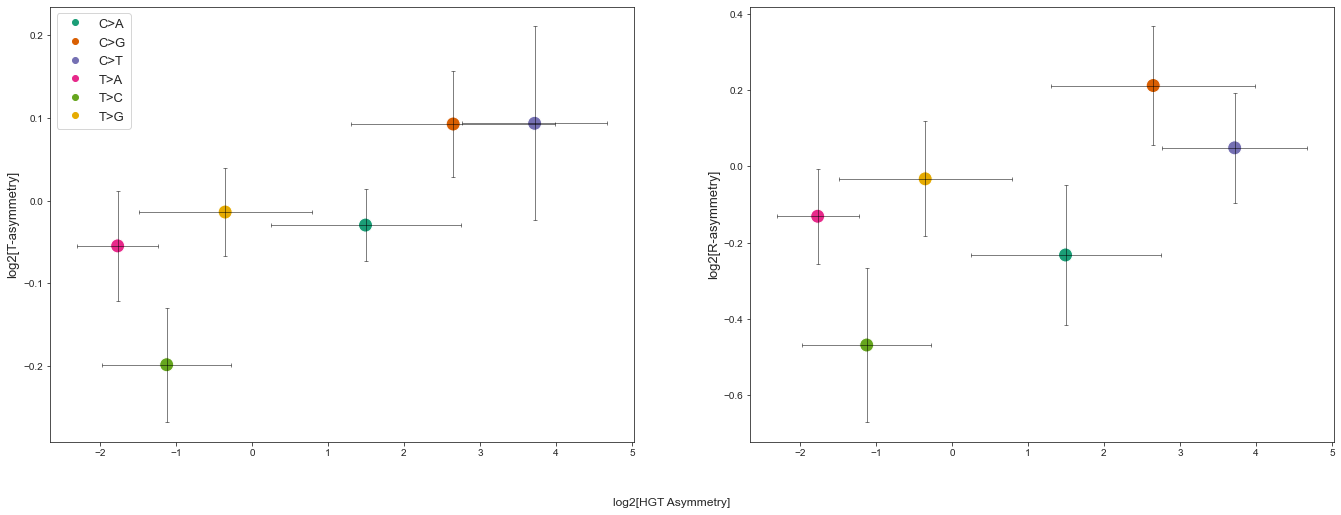

In [284]:
fig, axes = plt.subplots(1,2, sharex=False, figsize=(18,5))
sns.set_style("ticks")

sns.scatterplot(y="T_mean", x="hgt_mean", data=err_hgt, palette="Dark2", 
                hue="Mutation Base", s=200, ax=axes[0])
axes[0].errorbar(y="T_mean", x="hgt_mean", xerr='hgt_sd', yerr='T_sd', fmt='None', elinewidth=0.5, 
             data=err_hgt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[0].tick_params(axis='x')
axes[0].legend(loc='upper left', scatteryoffsets=[0.55], frameon=True, fontsize=11, ncol=1)
axes[0].set_xlabel("")
axes[0].set_xlim(-2.8,5.9)
axes[0].set_ylim(-0.35,0.4)
axes[0].set_ylabel("log2[T-asymmetry]", fontsize=15)


sns.scatterplot(y="R_mean", x="hgt_mean", data=err_hgt, palette="Dark2", 
                hue="Mutation Base", s=200, ax=axes[1])
axes[1].errorbar(y="R_mean", x="hgt_mean", xerr='hgt_sd', yerr='R_sd', fmt='None', elinewidth=0.5, 
             data=err_hgt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[1].tick_params(axis='x')
axes[1].legend([],[], frameon=False)
axes[1].set_xlabel("")
axes[1].set_xlim(-2.8,5.9)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_ylabel("log2[R-asymmetry]", fontsize=15)

fig.supxlabel('log2[HGT Asymmetry]', size=15)
#fig.savefig("../pictures/AsymmetryErrorBarsHGT.pdf", dpi=300)

### Six types of base substitutions


In [86]:
bs_subs = ['C>A', 'T>A', 'C>G', 'T>C', 'C>T', 'T>G']

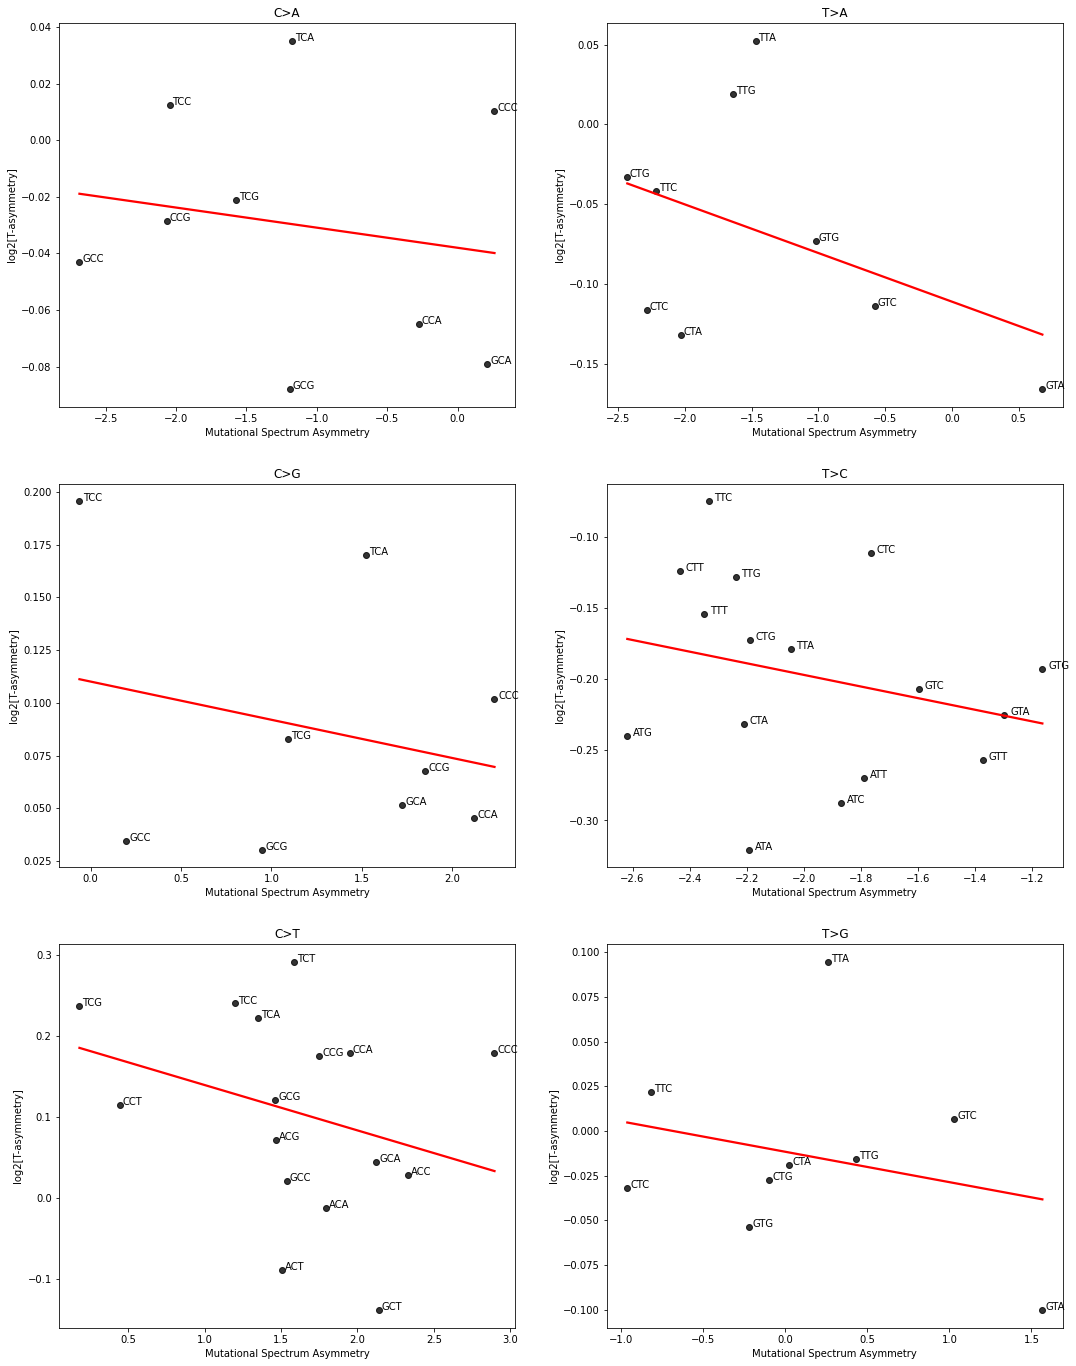

In [87]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry.MutBase == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='T', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['T'], to_draw.AncestorCodon, ax)
    ax.set_title(sub)
    ax.set_xlabel('Mutational Spectrum Asymmetry')
    ax.set_ylabel('log2[T-asymmetry]')
#fig.savefig('../pictures/AsymmetryMutBaseT.pdf', dpi=300)

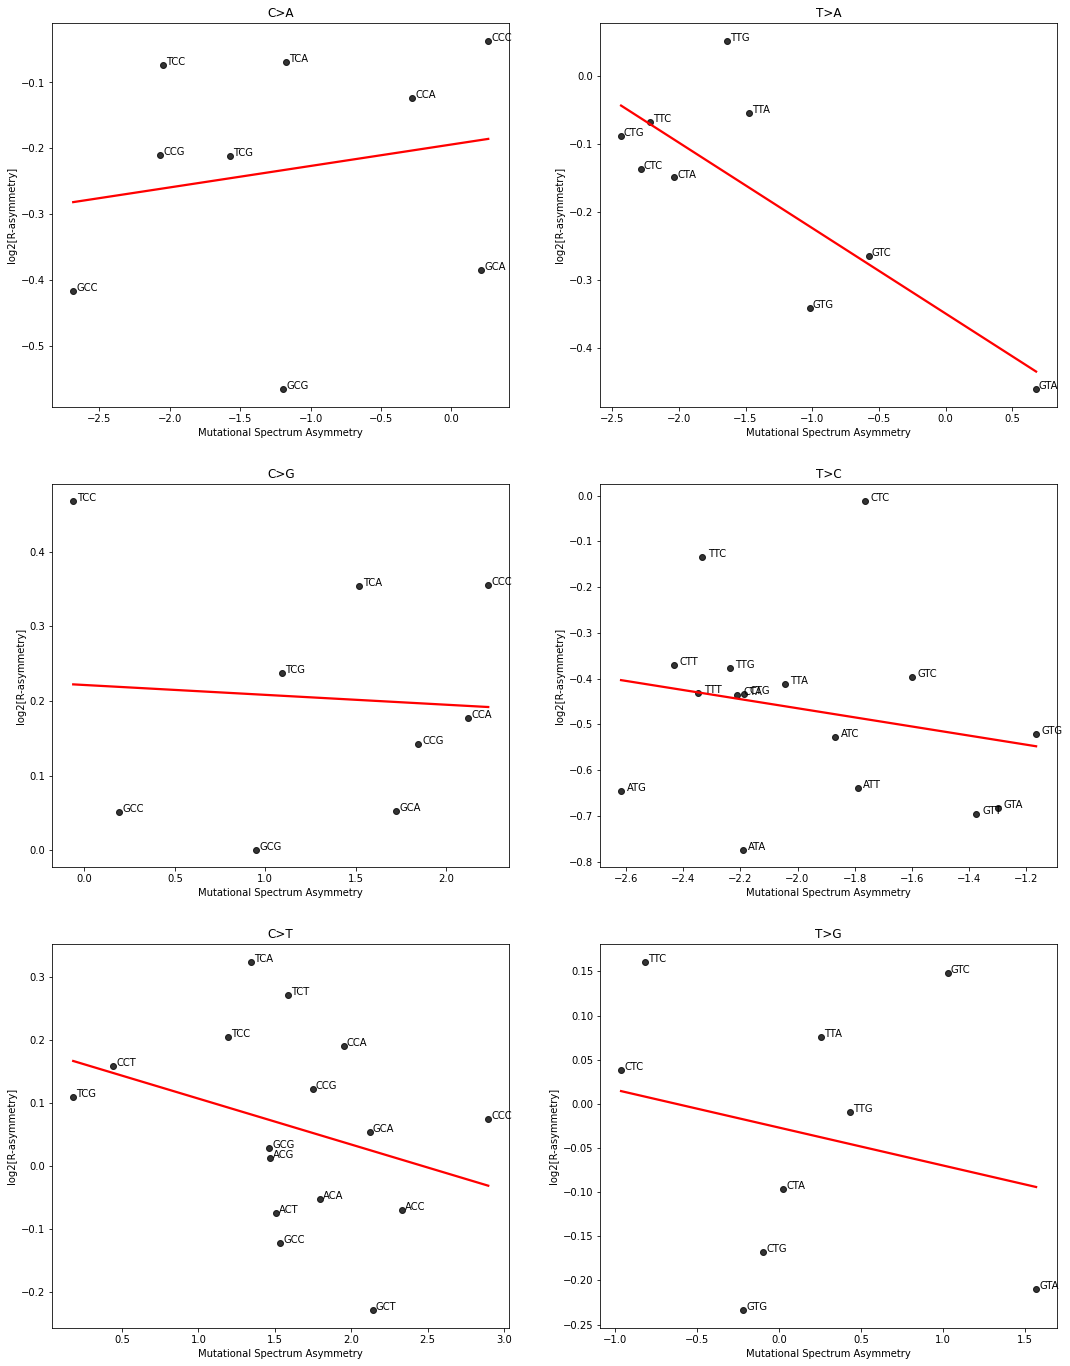

In [88]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry.MutBase == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='R', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['R'], to_draw.AncestorCodon, ax)
    ax.set_title(sub)
    ax.set_xlabel('Mutational Spectrum Asymmetry')
    ax.set_ylabel('log2[R-asymmetry]')
#fig.savefig('../pictures/AsymmetryMutBaseR.pdf', dpi=300)

### Made cor test with spearman for each combination of R/T and MutSpec

In [89]:
cor_res = []
for sub in bs_subs:
    to_cor = final_asymmetry[final_asymmetry.MutBase == sub]
    T_cor = stats.spearmanr(to_cor['T'].values, to_cor.MutSpec.values, axis=0)
    R_cor = stats.spearmanr(to_cor['R'].values, to_cor.MutSpec.values, axis=0)
    out_line = {'MutBase': sub, 'T_asymmetry_cor': T_cor.correlation, 'R_asymmetry_cor': R_cor.correlation}
    cor_res.append(out_line)
cor_res = pd.DataFrame(cor_res)
cor_res

,MutBase,T_asymmetry_cor,R_asymmetry_cor
0,C>A,-0.066667,0.400000
1,T>A,-0.266667,-0.533333
2,C>G,0.016667,0.133333
3,T>C,-0.279412,-0.279412
4,C>T,-0.376471,-0.382353
5,T>G,0.033333,-0.116667


### Damage analysis

In [90]:
main_subs = ['C>T', 'A>G', 'G>T', 'A>T', 'C>G', 'A>C']

In [91]:
damage = []
for mutbase in main_subs:
    cont_mb = mut_vert[mut_vert.MutBase == mutbase].Mut
    for context in cont_mb:
        mutspec_main = mut_vert[mut_vert.Mut == context].MutSpec.values[0]
        mutspec_rev = mut_vert[mut_vert.Mut == gettranslate(context, reverse=True)].MutSpec.values[0]
        out_damage = {'Mut':context,'ReverseMut':gettranslate(context, reverse=True), 'MutSpecDif':mutspec_main-mutspec_rev}
        damage.append(out_damage)
damage = pd.DataFrame(damage)
damage.head()

,Mut,ReverseMut,MutSpecDif
0,A[C>T]A,T[G>A]T,0.024372
1,A[C>T]C,G[G>A]T,0.029733
2,A[C>T]G,C[G>A]T,0.015401
3,A[C>T]T,A[G>A]T,0.011718
4,C[C>T]A,T[G>A]G,0.025892


In [92]:
damage.MutSpecDif.sum()

0.5245771260547207

## Linear models witn mtDNA asymmetry and HGT

### Linear model for mtDNA mutational spectrum of vertebrates

In [124]:
mtdna_reg = linear_model.LinearRegression()
mtdna_reg.fit(final_asymmetry[['T','R']].to_numpy(), final_asymmetry.MutSpec.to_numpy())
print('Coefficient for mtDNA model with T and R asymmetry', mtdna_reg.coef_)
print('Intercept:', mtdna_reg.intercept_)

Coefficient for mtDNA model with T and R asymmetry [4.88581761 1.44503543]
Intercept: 0.061236412936487405


### Linear model for HGT

In [236]:
hgt_reg = linear_model.LinearRegression()
hgt_reg.fit(hgt_cl[['T','R']].to_numpy(), hgt_cl['HGT_Asymmetry_log2'])
print('Coefficient for HGT model with T and R asymmetry', hgt_reg.coef_)
print('Intercept:', hgt_reg.intercept_)

Coefficient for HGT model with T and R asymmetry [15.66473211 -2.7234714 ]
Intercept: 0.9304347131726552


# Cold versus Short comparison T and R asymmetry

### In our case cold is fish and warm is birds

### First, calculate a mutational spectrum for fishes and birds

In [118]:
mut_spec = pd.read_csv('../data/MutSpecVertebratescytb.csv')
mut_spec.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [119]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

In [120]:
fish_mut = calc_mutspec_class(mut_spec[mut_spec.Class == 'Actinopterygii'])
aves_mut = calc_mutspec_class(mut_spec[mut_spec.Class == 'Aves'])

### Transform our 192 comp mutspec of each class to 96 comp mutspec

In [121]:
fish_mut['MutBase'] = fish_mut.Mut.str.slice(2,5)
fish_mut['AncestorCodon'] = fish_mut.Mut.str.get(0) + fish_mut.Mut.str.get(2) + fish_mut.Mut.str.get(-1)
aves_mut['MutBase'] = aves_mut.Mut.str.slice(2,5)
aves_mut['AncestorCodon'] = aves_mut.Mut.str.get(0) + aves_mut.Mut.str.get(2) + aves_mut.Mut.str.get(-1)

In [122]:
fish_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=fish_mut)
aves_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=aves_mut)

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_23121/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_23121/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_23121/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_23121/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


### Delete subs with context that mutspec euqal 0 and log2 those mutspecs

In [131]:
fish_final = assymetry.merge(right = fish_96_comp, on=['AncestorCodon', 'MutBase'])
fish_final = fish_final[fish_final.MutSpec != 0]
fish_final.MutSpec = np.log2(fish_final.MutSpec)
fish_final['ColdWarm'] = 'Cold'

aves_final = assymetry.merge(right = aves_96_comp, on=['AncestorCodon', 'MutBase'])
aves_final = aves_final[aves_final.MutSpec != 0]
aves_final.MutSpec = np.log2(aves_final.MutSpec)
aves_final['ColdWarm'] = 'Warm'

cold_warm = pd.concat([aves_final, fish_final])
cold_warm['Mut'] = cold_warm.AncestorCodon.str.get(0) + '[' + cold_warm.MutBase.str.get(0) + '>'  + cold_warm.MutBase.str.get(-1) + ']' + cold_warm.AncestorCodon.str.get(-1)
cold_warm = cold_warm.rename(columns={'ColdWarm':'Temperature', 'MutSpec':'mtDNA Mutational Spectrum'})
cold_warm.head()

,AncestorCodon,MutBase,T,R,mtDNA Mutational Spectrum,Temperature,Mut
2,ACA,C>T,-0.012015,-0.052744,2.604617,Warm,A[C>T]A
5,ACC,C>T,0.028556,-0.069531,2.791319,Warm,A[C>T]C
8,ACG,C>T,0.071747,0.012317,0.434442,Warm,A[C>T]G
11,ACT,C>T,-0.088058,-0.074512,2.597737,Warm,A[C>T]T
13,ATA,T>C,-0.320754,-0.774055,-3.971254,Warm,A[T>C]A


### Draw plots

In [125]:
cold_warm.melt(["Mut", "ColdWarm", "MutSpec"], ["T", "R"], value_name="Asymmetry", var_name="Nuclear Asymmetry")

,Mut,ColdWarm,MutSpec,Nuclear Asymmetry,Asymmetry
0,A[C>T]A,Warm,2.604617,T,-0.012015
1,A[C>T]C,Warm,2.791319,T,0.028556
2,A[C>T]G,Warm,0.434442,T,0.071747
3,A[C>T]T,Warm,2.597737,T,-0.088058
4,A[T>C]A,Warm,-3.971254,T,-0.320754
...,...,...,...,...,...
253,T[T>G]C,Cold,-0.773554,R,0.161242
254,T[T>A]G,Cold,-1.435210,R,0.052712
255,T[T>C]G,Cold,-1.050997,R,-0.376439
256,T[T>G]G,Cold,0.515952,R,-0.009426


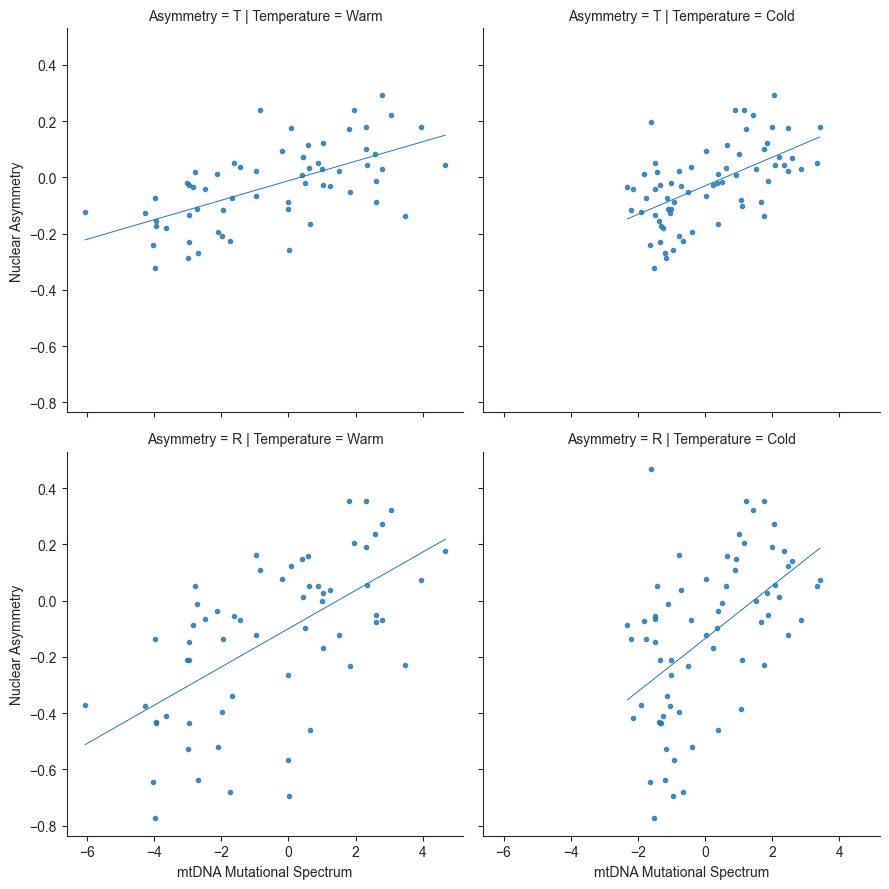

In [138]:
sns.lmplot(data=cold_warm.melt(["Mut", "Temperature", "mtDNA Mutational Spectrum"], ["T", "R"],
                                value_name="Nuclear Asymmetry", var_name="Asymmetry"),
                                x="mtDNA Mutational Spectrum", y="Nuclear Asymmetry", 
                                col="Temperature", row="Asymmetry", height=4.5, 
                                markers=".", ci=None, line_kws={"linewidth": 0.7})
plt.savefig('../pictures/AsymmentryVSColdVSWarm.pdf', dpi=300)


In [146]:
warm_df = cold_warm[cold_warm.Temperature == 'Warm']
cold_df = cold_warm[cold_warm.Temperature == 'Cold']

In [147]:
T_warm = stats.spearmanr(warm_df['T'].values, warm_df['mtDNA Mutational Spectrum'].values, axis=0)
T_cold = stats.spearmanr(cold_df['T'].values, cold_df['mtDNA Mutational Spectrum'].values, axis=0)
R_warm = stats.spearmanr(warm_df['R'].values, warm_df['mtDNA Mutational Spectrum'].values, axis=0)
R_cold = stats.spearmanr(cold_df['R'].values, cold_df['mtDNA Mutational Spectrum'].values, axis=0)

### Warm is bigger than cold?

In [303]:
check_temp = fish_final.merge(right=aves_final[['AncestorCodon', 'MutBase', 'MutSpec']], on=['AncestorCodon', 'MutBase'])
check_temp = check_temp.drop(['ColdWarm'], axis=1)
check_temp = check_temp.rename(columns={'MutSpec_x': 'MutSpecFish', 'MutSpec_y': 'MutSpecBirds'})
check_temp['MutSpecFish'] = abs(check_temp['MutSpecFish'])
check_temp['MutSpecBirds'] = abs(check_temp['MutSpecBirds'])
check_temp['WarmVsCold'] = check_temp['MutSpecBirds'] / check_temp['MutSpecFish']

In [304]:
check_temp.head()

,AncestorCodon,MutBase,T,R,MutSpecFish,MutSpecBirds,WarmVsCold
0,ACA,C>T,-0.012015,-0.052744,1.863106,2.604617,1.397998
1,ACC,C>T,0.028556,-0.069531,2.848228,2.791319,0.980019
2,ACG,C>T,0.071747,0.012317,2.212966,0.434442,0.196316
3,ACT,C>T,-0.088058,-0.074512,1.667049,2.597737,1.558285
4,ATA,T>C,-0.320754,-0.774055,1.517331,3.971254,2.617264


In [332]:
stats.wilcoxon(x=check_temp.MutSpecBirds, y=check_temp.MutSpecFish, alternative='greater')

WilcoxonResult(statistic=1544.0, pvalue=8.582733829754599e-06)

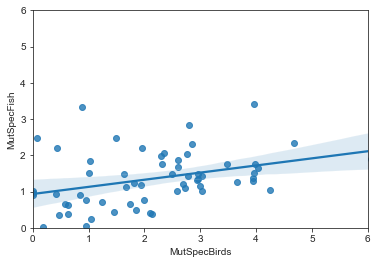

In [328]:
sns.regplot(data = check_temp, x='MutSpecBirds', y='MutSpecFish')
plt.xlim(0,6)
plt.ylim(0,6)
plt.show()

In [326]:
mod_sp = sm.GLM(check_temp.MutSpecFish, sm.add_constant(check_temp.MutSpecBirds)).fit()
print(mod_sp.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            MutSpecFish   No. Observations:                   61
Model:                            GLM   Df Residuals:                       59
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.49512
Method:                          IRLS   Log-Likelihood:                -64.098
Date:                Mon, 20 Feb 2023   Deviance:                       29.212
Time:                        18:12:17   Pearson chi2:                     29.2
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1295
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9333      0.171      5.460   